<br>

<h1 style="text-align:center;">Reinforcement Learning from Human Feedback (RLHF) <br> in Llama 2</h1>

<br>

## Introduction

---

In [ ]:
# !pip3 install google-cloud-pipeline-components
# !pip3 install google-cloud-aiplatform
# !pip3 install kfp
# !pip install tensorboard

In [ ]:
# Import the libraries
import json
import math
from google_cloud_pipeline_components.preview.llm import rlhf_pipeline
from kfp import compiler
from utils import authenticate, print_d
import google.cloud.aiplatform as aiplatform
import pandas as pd

In [ ]:
pd.set_option('display.max_colwidth', None)

<br>

## Data Prepration

---

RLHF requires the following datasets:
- __Preference dataset__: Input prompt, candidate response 0, candidate response 1, choice (candidate 0 or 1)
- __Prompt dataset__: Input prompt only, no response.

All the prompts come from [Reddit posts](https://github.com/openai/summarize-from-feedback).

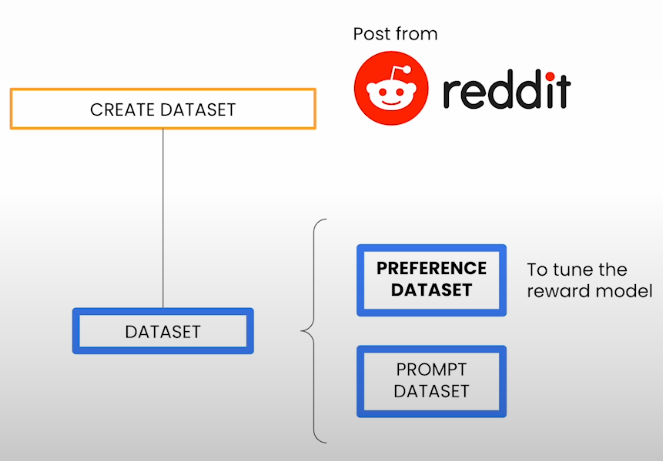

##### Preference dataset

In [13]:
# Load preference dataset
preference_dataset_path = './dataset/sample_preference.jsonl'
with open(preference_dataset_path) as f:
    preference_data = [json.loads(line) for line in f]

# Sample data
sample_1 = preference_data[0]

# Print type and keys of the sample
print(type(sample_1))
print(sample_1.keys())

<class 'dict'>
dict_keys(['input_text', 'candidate_0', 'candidate_1', 'choice'])


In [15]:
# Access specific fields in the sample
print(sample_1['input_text'])
print(preference_data[2]['input_text'][-50:])

I live right next to a huge university, and have been applying for a variety of jobs with them through their faceless electronic jobs portal (the "click here to apply for this job" type thing) for a few months. 

The very first job I applied for, I got an interview that went just so-so. But then, I never heard back (I even looked up the number of the person who called me and called her back, left a voicemail, never heard anything).

Now, when I'm applying for subsequent jobs - is it that same HR person who is seeing all my applications?? Or are they forwarded to the specific departments?

I've applied for five jobs there in the last four months, all the resumes and cover letters tailored for each open position. Is this hurting my chances? I never got another interview there, for any of the positions. [summary]: 
plan something in those circumstances. [summary]: 


In [10]:
# Print candidates and human labeler's choice
# In here choice 1 means candidate_0 is better than candidate_1
print(f"candidate_0:\n{sample_1.get('candidate_0')}\n")
print(f"candidate_1:\n{sample_1.get('candidate_1')}\n")
print(f"choice: {sample_1.get('choice')}")

candidate_0:
 When applying through a massive job portal, is just one HR person seeing ALL of them?

candidate_1:
 When applying to many jobs through a single university jobs portal, is just one HR person reading ALL my applications?

choice: 1


##### Prompt dataset

In [16]:
# Load prompt dataset
prompt_dataset_path = './dataset/sample_prompt.jsonl'
with open(prompt_dataset_path) as f:
    prompt_data = [json.loads(line) for line in f]

# Print the number of prompts in the dataset
print(len(prompt_data))

6


In [9]:
# Function to print the information in the prompt dataset with a better visualization
def print_d(d):
    for key, val in d.items():        
        print(f"key:{key}\nval:{val}\n")

print_d(prompt_data[0])

# Try with another prompt from the list 
print_d(prompt_data[1])

key:input_text
val:I noticed this the very first day! I took a picture of it to send to one of my friends who is a fellow redditor. Later when I was getting to know my suitemates, I asked them if they ever used reddit, and they showed me the stencil they used to spray that! Along with the lion which is his trademark. 
 But [summary]: 

key:input_text
val:Nooooooo, I loved my health class! My teacher was amazing! Most days we just went outside and played and the facility allowed it because the health teacher's argument was that teens need to spend time outside everyday and he let us do that. The other days were spent inside with him teaching us how to live a healthy lifestyle. He had guest speakers come in and reach us about nutrition and our final was open book...if we even had a final.... [summary]: 



<br>

## Tune an LLM using RLHF

--- 

The RLHF training process is implemented in the Google Cloud Pipeline Components library. It runs on any platform supporting KubeFlow Pipelines and Google Cloud's Vertex AI Pipelines.

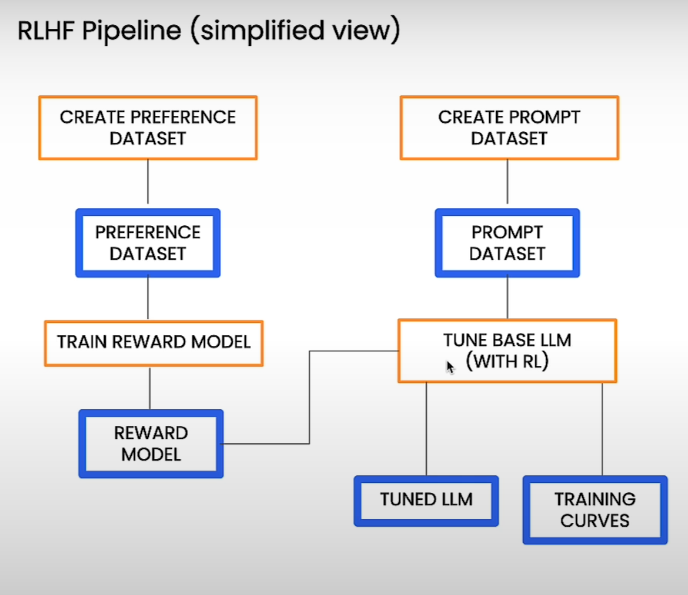

##### Compile the pipeline

In [18]:
# Define a path to the yaml file
RLHF_PIPELINE_PKG_PATH = "rlhf_pipeline.yaml"

In [19]:
# Execute the compile function
compiler.Compiler().compile(
    pipeline_func=rlhf_pipeline,
    package_path=RLHF_PIPELINE_PKG_PATH
)

In [20]:
# Print the first lines of the YAML file
!head rlhf_pipeline.yaml

# PIPELINE DEFINITION
# Name: rlhf-train-template
# Description: Performs reinforcement learning from human feedback.
# Inputs:
#    accelerator_type: str [Default: 'GPU']
#    deploy_model: bool [Default: True]
#    encryption_spec_key_name: str [Default: '']
#    eval_dataset: str
#    instruction: str
#    kl_coeff: float [Default: 0.1]


##### Specify the data location
Datasets for training and evaluation are typically stored in Google Cloud Storage rather than local JSONL files.

**Note:** Ensure all three datasets are in the same Google Cloud Storage bucket.#

```Python
parameter_values={
        "preference_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train/*.jsonl",
        "eval_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/val/*.jsonl",
    ...
```

##### Select the foundation model

We are tuning the [Llama-2](https://ai.meta.com/llama/) model, specifically **llama-2-7b**. You can also use Vertex AI to tune other models like T5x or text-bison@001.

```Python
parameter_values={
        "large_model_reference": "llama-2-7b",
        ...
```

##### Calculate reward model training steps

**reward_model_train_steps** is based on your preference dataset size. Aim for 20-30 epochs for optimal results.

$$ stepsPerEpoch = \left\lceil \frac{datasetSize}{batchSize} \right\rceil$$
$$ trainSteps = stepsPerEpoch \times numEpochs$$

The RLHF pipeline requires training steps, not epochs. With a fixed batch size of 64, convert epochs to training steps as shown.

In [28]:
# Initialize the constants
PREF_DATASET_SIZE = 3000     # Preference dataset size
BATCH_SIZE = 64              # Batch size is fixed at 64
REWARD_NUM_EPOCHS = 30       # Number of epochs for the reward model

In [29]:
REWARD_STEPS_PER_EPOCH = math.ceil(PREF_DATASET_SIZE / BATCH_SIZE)
print(REWARD_STEPS_PER_EPOCH)

47


In [27]:
# Calculate number of steps in the reward model training
reward_model_train_steps = REWARD_STEPS_PER_EPOCH * REWARD_NUM_EPOCHS

print(reward_model_train_steps)

1410


##### Determine RL training steps

**reinforcement_learning_train_steps** specifies the number of RL steps for tuning the base model. 

- Typically, train for 10-20 epochs based on your prompt dataset size.
- Avoid excessive steps to prevent reward hacking and undesired behavior.

In [33]:
# Initialize the constants
PROMPT_DATASET_SIZE = 2000            # Prompt dataset size
BATCH_SIZE = 64                       # Batch size is fixed at 64
RL_NUM_EPOCHS = 10                    # Number of epochs for the RL model

In [32]:
# Calculate number of steps in the reward model training
RL_STEPS_PER_EPOCH = math.ceil(PROMPT_DATASET_SIZE / BATCH_SIZE)
print(RL_STEPS_PER_EPOCH)

32


In [34]:
# Calculate the number of steps in the RL training
reinforcement_learning_train_steps = RL_STEPS_PER_EPOCH * RL_NUM_EPOCHS
print(reinforcement_learning_train_steps)

320


##### Set the instruction

- Select the task-specific instruction for tuning the model. Example: "Summarize in less than 50 words."
- Ensure your preference dataset uses the same instruction to align responses and human preferences.

In [35]:
# Completed values for the dictionary
parameter_values={
        "preference_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train/*.jsonl",
        "eval_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/val/*.jsonl",
        "large_model_reference": "llama-2-7b",
        "reward_model_train_steps": 1410,
        "reinforcement_learning_train_steps": 320, # results from the calculations above
        "reward_model_learning_rate_multiplier": 1.0,
        "reinforcement_learning_rate_multiplier": 1.0,
        "kl_coeff": 0.1, # increased to reduce reward hacking
        "instruction":\
    "Summarize in less than 50 words"}

##### Set the instruction

- Select the task-specific instruction for tuning the model. Example: "Summarize in less than 50 words."
- Ensure your preference dataset uses the same instruction to align responses and human preferences.

```python
parameter_values={
        "preference_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text/reddit_tfds/train/*.jsonl",
        "eval_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text/reddit_tfds/val/*.jsonl",
        "large_model_reference": "llama-2-7b",
        "reward_model_train_steps": 10000,
        "reinforcement_learning_train_steps": 10000, 
        "reward_model_learning_rate_multiplier": 1.0,
        "reinforcement_learning_rate_multiplier": 0.2,
        "kl_coeff": 0.1,
        "instruction":\
    "Summarize in less than 50 words"}
```

##### Configure Google Cloud for Vertex AI pipeline

Vertex AI is pre-installed in this environment. For other projects, install Vertex AI SDK as follows:

In [ ]:
# Authenticate in utils
credentials, PROJECT_ID, STAGING_BUCKET = authenticate()

# RLFH pipeline is available in this region
REGION = "europe-west4"

##### Execute the pipeline on Vertex AI

Create a `PipelineJob` to run the RLHF pipeline on Vertex AI, executing on Google Cloud servers instead of locally.

In [ ]:
aiplatform.init(project = PROJECT_ID,
                location = REGION,
                credentials = credentials)

In [ ]:
# Look at the path for the YAML file
RLHF_PIPELINE_PKG_PATH

##### Create and run the pipeline job

To create and run the pipeline job:

```Python
job = aiplatform.PipelineJob(
    display_name="tutorial-rlhf-tuning",
    pipeline_root=STAGING_BUCKET,
    template_path=RLHF_PIPELINE_PKG_PATH,
    parameter_values=parameter_values
)
job.run()

<br>

## Evaluation

---

Some approaches we can take for evaluation.

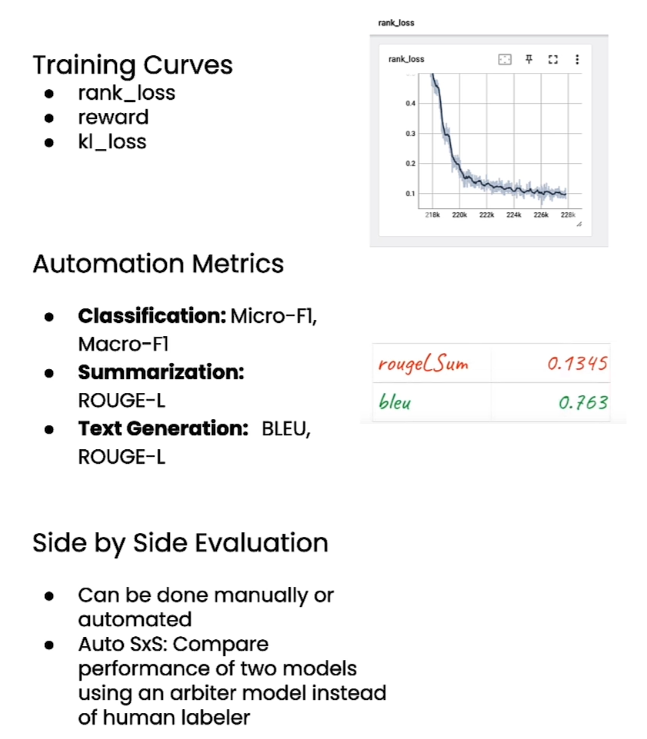

##### Explore results with Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
port = %env PORT1
%tensorboard --logdir reward-logs --port $port --bind_all 

In [ ]:
# Look at what this directory has
%ls reward-logs

In [ ]:
port = %env PORT2
%tensorboard --logdir reinforcer-logs --port $port --bind_all

In [ ]:
port = %env PORT3
%tensorboard --logdir reinforcer-fulldata-logs --port $port --bind_all

In [ ]:
parameter_values={
        "preference_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train/*.jsonl",
        "eval_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/val/*.jsonl",
        "large_model_reference": "llama-2-7b",
        "reward_model_train_steps": 1410,
        "reinforcement_learning_train_steps": 320,
        "reward_model_learning_rate_multiplier": 1.0,
        "reinforcement_learning_rate_multiplier": 1.0,
        "kl_coeff": 0.1,
        "instruction":\
    "Summarize in less than 50 words"}

##### Evaluate using the tuned and untuned model

In [42]:
eval_tuned_path = 'eval_results_tuned.jsonl'

# Load evaluation results from the tuned model
with open(eval_tuned_path) as f:
    eval_data_tuned = [json.loads(line) for line in f]

# Display the first result
print_d(eval_data_tuned[0])

key:inputs
val:{'inputs_pretokenized': "Summarize in less than 50 words.\n\n\nBefore anything, not a sad story or anything. My country's equivalent to Valentine's Day is coming and I had this pretty simple idea to surprise my girlfriend and it would involve giving her some roses. The thing is, although I know she would appreciate my intention in and of itself, I don't know if she would like the actual flowers and such, so I wanted to find out if she likes roses and if she would like getting some, but without her realizing it so as not to spoil the surprise. Any ideas on how to get that information out of her? [summary]: ", 'targets_pretokenized': ''}

key:prediction
val:My country's equivalent to Valentine's Day is coming. Want to surprise my girlfriend with roses but don't know if she would like getting some. Any ideas on how to get that information out of her without spoiling the surprise



In [43]:
eval_untuned_path = 'eval_results_untuned.jsonl'

# Load evaluation results from the untuned model
with open(eval_untuned_path) as f:
    eval_data_untuned = [json.loads(line) for line in f]

# Display the first result
print_d(eval_data_untuned[0])

key:inputs
val:{'inputs_pretokenized': "Summarize in less than 50 words.\n\n\nBefore anything, not a sad story or anything. My country's equivalent to Valentine's Day is coming and I had this pretty simple idea to surprise my girlfriend and it would involve giving her some roses. The thing is, although I know she would appreciate my intention in and of itself, I don't know if she would like the actual flowers and such, so I wanted to find out if she likes roses and if she would like getting some, but without her realizing it so as not to spoil the surprise. Any ideas on how to get that information out of her? [summary]: ", 'targets_pretokenized': ''}

key:prediction
val:The author wants to surprise his girlfriend with roses on Valentine's Day but he doesn't know if she likes roses. He wants to find out without spoiling the surprise.



##### Explore the results side by side in a dataframe

In [ ]:
# Extract all the prompts
prompts = [sample['inputs']['inputs_pretokenized']
           for sample in eval_data_tuned]

# Completions from the untuned model
untuned_completions = [sample['prediction']
                       for sample in eval_data_untuned]

# Completions from the tuned model
tuned_completions = [sample['prediction']
                     for sample in eval_data_tuned]

In [ ]:
results = pd.DataFrame(
    data={'prompt': prompts,
          'base_model':untuned_completions,
          'tuned_model': tuned_completions})

results